In [1]:
import numpy as np
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

# Simulation

In [61]:
# Load simulation data
def df_sim(bag_name):
    b_sim = bagreader(bag_name)

    ODOM_SIM = b_sim.message_by_topic('/rr_robot/odom')
    SCAN_SIM = b_sim.message_by_topic('/scan')
    VEL_SIM = b_sim.message_by_topic('/velX')
    YAW_SIM = b_sim.message_by_topic('/yaw')

    df_odom = pd.read_csv(ODOM_SIM)
    df_scan = pd.read_csv(SCAN_SIM)
    df_vel = pd.read_csv(VEL_SIM)
    df_yaw = pd.read_csv(YAW_SIM)

    # Check minimum distance as observed by the fake laser
    df_ranges = df_scan.drop(df_scan.iloc[:, 1:12],axis = 1)
    df_le_dist = df_scan.drop(df_scan.iloc[:, 1:],axis = 1)
    ranges_min = df_ranges.min(axis=1)
    df_le_dist['ranges_min'] = ranges_min

    return df_vel, df_yaw, df_odom

df_vel, df_yaw, df_odom = df_sim('rosbag_sim/2023-04-19-10-50-24.bag')

[INFO]  Data folder rosbag_sim/2023-04-19-10-50-24 already exists. Not creating.


In [62]:
# Plot vel, yaw, le_dist
def df_plot(df_vel, df_yaw, df_odom, title=''):

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
    
    df_vel['Time'] = df_vel['Time'] - df_vel['Time'].iat[0]
    df_yaw['Time'] = df_yaw['Time'] - df_yaw['Time'].iat[0]
    df_odom['Time'] = df_odom['Time'] - df_odom['Time'].iat[0]
    df_odom['pose.pose.position.y'] = df_odom['pose.pose.position.y'] - df_odom['pose.pose.position.y'].iat[0]

    df_vel.plot(x='Time', xlabel='Time', y='data', ylabel='X-velocity [m/s]', legend=False, ax=axes[0], title=title)
    df_yaw.plot(x='Time', xlabel='Time', y='data', ylabel='Yaw [$^\circ$]', legend=False, ax=axes[1])
    df_odom.plot(x='Time', xlabel='Time', y='pose.pose.position.y', ylabel='Y-position[m]', legend=False, ax=axes[2])

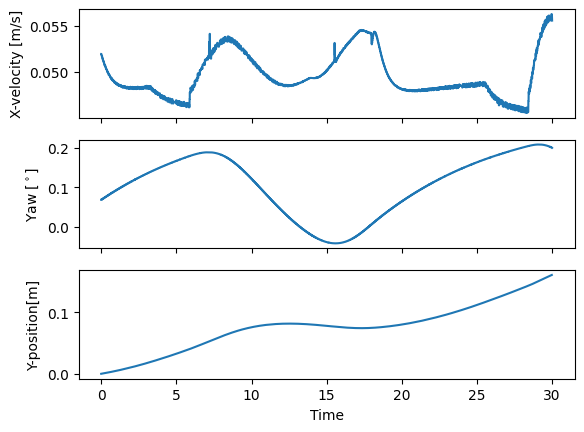

In [63]:
#for i in range(0,9):
#    df_plot(t_start[i], t_end[i], df_vel_exp, df_yaw_exp, df_le_dist_exp, df_steer_exp, title=f'')

df_plot(df_vel, df_yaw, df_odom)

# Experiment

\begin{array}{|l|l|l|l|l|}
\hline ID & Test name & Description & Date & File time \\
\hline 1 & \text { Fixed (0.0) } & \text { Top wheel 0, Yaw target 0 } & 21 / 04 / 2023 & 11.58 .31 \\
\hline 2 & \text { Fixed (6.0) } & \text { Top wheel 6, Yaw target 0 } & 21 / 04 / 2023 & 14.01 .45 \\
\hline 3 & \text { Fixed (-6.0) } & \text { Top wheel -6, Yaw target 0 } & 21 / 04 / 2023 & 14.05 .27 \\
\hline 4 & \text { Fixed (9.0) } & \text { Top wheel 9, Yaw target 0 } & 21 / 04 / 2023 & 14.14 .23 \\
\hline 5 & \text { Fixed (-9.0) } & \text { Top wheel -9, Yaw target 0 } & 21 / 04 / 2023 & 14.21 .41 \\
\hline 6 & \text { Fixed (0.5) } & \text { Top wheel 0, Yaw target 3 } & 21 / 04 / 2023 & 14.30 .38 \\
\hline 7 & \text { Fixed (0.-5) } & \text { Top wheel 0, Yaw target -3 } & 21 / 04 / 2023 & 14.37 .48 \\
\hline 8 & \text { Fixed (6.5) } & \text { Top wheel 6, Yaw target 3 } & 21 / 04 / 2023 & \\
\hline 9 & \text { Fixed (-6.-5) } & \text { Top wheel -6, Yaw target -3 } & 21 / 04 / 2023 & 14.41 .39 \\
\hline
\end{array}

In [10]:
# Load experiment data
b_exp1 = bagreader('rosbag_exp/secondary_2023-04-21-11-52-45_0.bag')
b_exp2 = bagreader('rosbag_exp/secondary_2023-04-21-13-59-49_0.bag')

[INFO]  Data folder rosbag_exp/secondary_2023-04-21-11-52-45_0 already exists. Not creating.
[INFO]  Data folder rosbag_exp/secondary_2023-04-21-13-59-49_0 already exists. Not creating.


In [45]:
pd.set_option('display.max_rows', 120)
#b_exp1.topic_table

In [11]:

LE_EXP1 = b_exp1.message_by_topic('/ackermann/robot_actual_le_dist')
VEL_EXP1 = b_exp1.message_by_topic('/rope_drive/encoder_velocity')
IMU_EXP1 = b_exp1.message_by_topic('/imu/processed_data')
WHEEL_EXP1 = b_exp1.message_by_topic('/rr_wheels/left_wheel_status')

LE_EXP2 = b_exp2.message_by_topic('/ackermann/robot_actual_le_dist')
VEL_EXP2 = b_exp2.message_by_topic('/rope_drive/encoder_velocity')
IMU_EXP2 = b_exp2.message_by_topic('/imu/processed_data')
WHEEL_EXP2 = b_exp2.message_by_topic('/rr_wheels/left_wheel_status')

df_le_dist_exp1 = pd.read_csv(LE_EXP1)
df_vel_exp1 = pd.read_csv(VEL_EXP1)
df_imu_exp1 = pd.read_csv(IMU_EXP1)
df_wheel_exp1 = pd.read_csv(WHEEL_EXP1)

df_le_dist_exp2 = pd.read_csv(LE_EXP2)
df_vel_exp2 = pd.read_csv(VEL_EXP2)
df_imu_exp2 = pd.read_csv(IMU_EXP2)
df_wheel_exp2 = pd.read_csv(WHEEL_EXP2)

df_le_dist_exp = df_le_dist_exp1.append(df_le_dist_exp2)
df_vel_exp = df_vel_exp1.append(df_vel_exp2)
df_imu_exp = df_imu_exp1.append(df_imu_exp2)
df_wheel_exp = df_wheel_exp1.append(df_wheel_exp2)

df_yaw_exp = df_imu_exp[['Time', 'euler_angles.yaw']]
df_steer_exp = df_wheel_exp[['Time', 'angle']]

In [12]:
t1_start = [11, 58, 31]
t1_end = [12, 2, 0]
t2_start = [14, 1, 45]
t2_end = [14, 4, 41]
t3_start = [14, 5, 27]
t3_end = [14, 14, 18]
t4_start = [14, 14, 23]
t4_end = [14, 20, 50]
t5_start = [14, 21, 41]
t5_end = [14, 29, 18]
t6_start = [14, 30, 38]
t6_end = [14, 36, 55]
t7_start = [14, 37, 48]
t7_end = [14, 40, 2]
t8_start = [14, 40, 2]
t8_end = [14, 40, 59]
t9_start = [14, 41, 39]
t9_end = [14, 50, 22]

t_start = [t1_start, t2_start, t3_start, t4_start, t5_start, t6_start, t7_start, t8_start, t9_start]
t_end = [t1_end, t2_end, t3_end, t4_end, t5_end, t6_end, t7_end, t8_end, t9_end]

In [23]:
# Get data from experiment date times
year = 2023
month = 4
day = 21
GMT_offset = 2*3600

def df_time_span(t_start_lst, t_end_lst, df):

    dt_start = datetime.datetime(year, month, day, t_start_lst[0], t_start_lst[1], t_start_lst[2])
    dt_end = datetime.datetime(year, month, day, t_end_lst[0], t_end_lst[1], t_end_lst[2])

    t_start = time.mktime(dt_start.timetuple())
    t_end = time.mktime(dt_end.timetuple())
    
    df_timed = df[(df.Time >= t_start) & (df.Time <= t_end)].copy()

    df_timed['Time'] = pd.to_datetime(df_timed['Time']+GMT_offset, unit='s').dt.time

    # df_timed['Time'] = df_timed['Time'] - t_start

    return df_timed

# Plot vel, yaw, le_dist
def df_plot(t_start_lst, t_end_lst, df_vel, df_yaw, df_le_dist, df_steer, title=''):

    df_vel_timed =  df_time_span(t_start_lst, t_end_lst, df_vel)
    df_yaw_timed = df_time_span(t_start_lst, t_end_lst, df_yaw)
    df_le_dist_timed = df_time_span(t_start_lst, t_end_lst, df_le_dist)
    df_steer_timed = df_time_span(t_start_lst, t_end_lst, df_steer)

    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
    
    df_vel_timed.plot(x='Time', xlabel='Time', y='data', ylabel='X-velocity [m/s]', legend=False, ax=axes[0], title=title)
    df_yaw_timed.plot(x='Time', xlabel='Time', y='euler_angles.yaw', ylabel='Yaw [$^\circ$]', legend=False, ax=axes[1])
    df_steer_timed.plot(x='Time', xlabel='Time', y='angle', ylabel='Steering [$^\circ$]', legend=False, ax=axes[2])
    df_le_dist_timed.plot(x='Time', xlabel='Time', y='data', ylabel='LE distance [m]', legend=False, ax=axes[3])

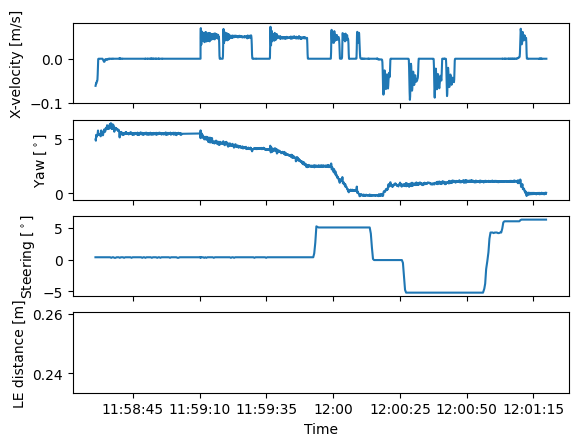

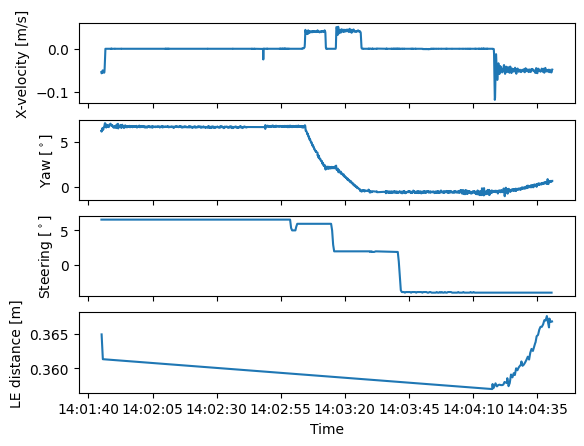

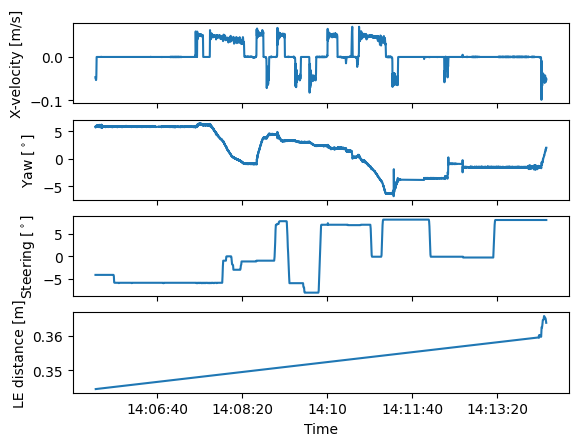

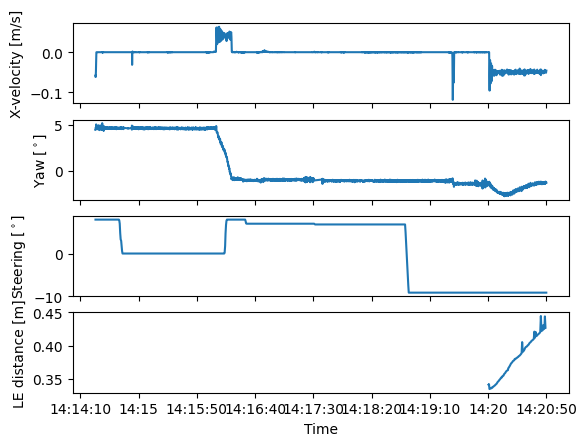

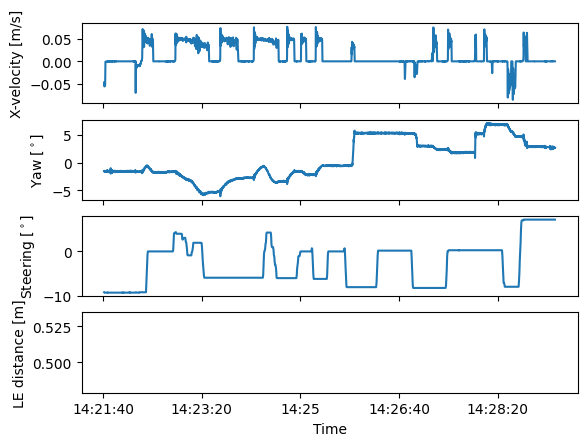

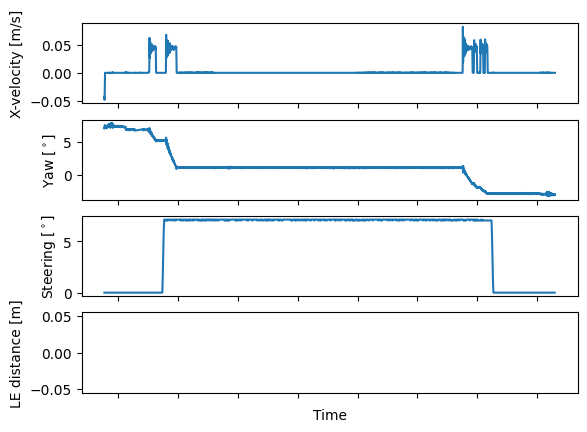

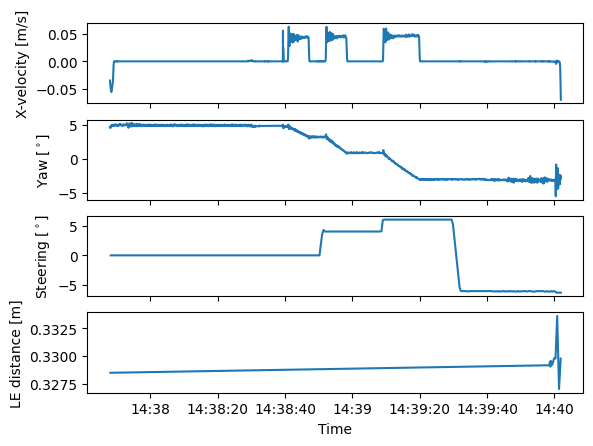

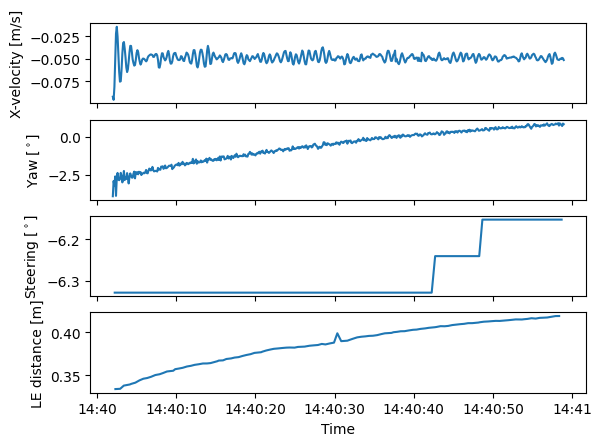

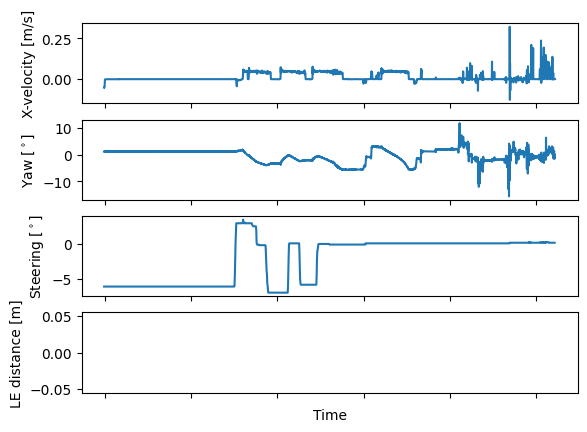

In [48]:
for i in range(0,9):
    df_plot(t_start[i], t_end[i], df_vel_exp, df_yaw_exp, df_le_dist_exp, df_steer_exp, title=f'')